# Random Forest for classifying AI-generated tweet and human-generated tweet


## Loading Datasets

In [2]:
import pandas as pd
train_df = pd.read_csv('dataset/train.csv')
valid_df = pd.read_csv('dataset/validation.csv')
test_df = pd.read_csv('dataset/test.csv')

In [3]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


## Preprocessing the Text Data

In [4]:
import re
from nltk.corpus import stopwords
import spacy

if not spacy.util.is_package('en_core_web_sm'):
    spacy.cli.download("en_core_web_sm")

nlp = spacy.load('en_core_web_sm')


def preprocess_text(text):
    """ Method to clean reviews from noise and standardize text across the different classes.
    Arguments
    ---------
    text : String
        Text to clean
    Returns
    -------
    text : String
        Cleaned text
    """
    stop_words = set(stopwords.words('english'))
    
    text = text.lower() # Convert text to lowercase
    text = text.replace('\n', ' ') # Remove newline characters and extra spaces
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'[^\w\s]', ' ', text) # Remove punctuation and special characters
    text = re.sub(r'\d+', ' ', text) # Remove digits
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stopwords
    text = ' '.join( [token.lemma_ for token in nlp(text)]) # Lemmatize text

    return text

/Users/ujas/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_text(x))
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_text(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess_text(x))

In [6]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,yea note good,bot,others
1,zawvrk,listen charming man smith,human,human
2,zawarbot,wish would see hoe bad part,bot,others
3,ahadsheriffbot,decade significantly easy schedule like h,bot,others
4,kevinhookebot,theim class alignnone size full wp image src a...,bot,rnn


## Preparing the Features and Labels

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()


X_train = tfidf_vectorizer.fit_transform(train_df['text'])
y_train = train_df['account.type']

X_val = tfidf_vectorizer.transform(valid_df['text'])
y_val = valid_df['account.type']

X_test = tfidf_vectorizer.transform(test_df['text'])
y_test = test_df['account.type']

In [8]:
X_train.shape, X_val.shape, X_test.shape

((20712, 25441), (2302, 25441), (2558, 25441))

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [10]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("--------------------------------------------------------")
valid_preds = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, valid_preds))
print("Classification Report:\n", classification_report(y_val, valid_preds))


print("--------------------------------------------------------")
test_preds = rf_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Classification Report:\n", classification_report(y_test, test_preds))

--------------------------------------------------------
Validation Accuracy: 0.6320590790616855
Classification Report:
               precision    recall  f1-score   support

         bot       0.77      0.38      0.51      1152
       human       0.59      0.89      0.71      1150

    accuracy                           0.63      2302
   macro avg       0.68      0.63      0.61      2302
weighted avg       0.68      0.63      0.61      2302

--------------------------------------------------------
Test Accuracy: 0.6336982017200938
Classification Report:
               precision    recall  f1-score   support

         bot       0.77      0.38      0.51      1280
       human       0.59      0.89      0.71      1278

    accuracy                           0.63      2558
   macro avg       0.68      0.63      0.61      2558
weighted avg       0.68      0.63      0.61      2558



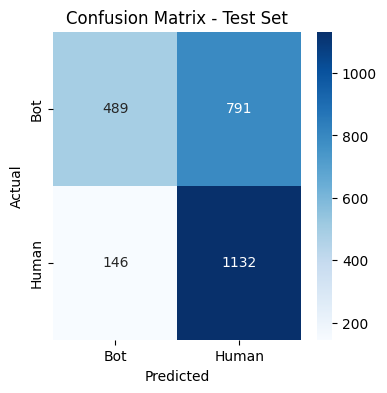

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_test = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
test_sentence = """Problem solved in 25 seconds. The police in Brazil don't joke."""
test_sentence = preprocess_text(test_sentence)
test_sentence_vectorized = tfidf_vectorizer.transform([test_sentence])
test_preds = rf_model.predict(test_sentence_vectorized)
print("Test Sentence:", test_sentence)
print("Prediction:", test_preds[0])

Test Sentence: problem solve second police brazil joke
Prediction: bot


## Hyperparameter Tuning

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

results_table = cv_results[
    ["mean_test_score", "std_test_score", "param_n_estimators", "param_max_depth", "param_min_samples_split"]
].sort_values(by="mean_test_score", ascending=False)

print("Best Parameters:", grid_search.best_params_)
print("\nResults Table:")
print(results_table)

best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

tuned_test_preds = best_rf_model.predict(X_test)
print("Tuned Test Accuracy:", accuracy_score(y_test, tuned_test_preds))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  25.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  25.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  25.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  23.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  24.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  51.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  51.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  52.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  23.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  47.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  46.5s
[CV] END max_depth=None, min_sa

In [15]:
#  write code to print precision, recall, f1-score and accuracy of best output with training parameters
from sklearn.metrics import classification_report

tuned_valid_preds = best_rf_model.predict(X_val)
print("Tuned Validation Accuracy:", accuracy_score(y_val, tuned_valid_preds))
print("Tuned Classification Report:\n", classification_report(y_val, tuned_valid_preds))

tuned_test_preds = best_rf_model.predict(X_test)
print("Tuned Test Accuracy:", accuracy_score(y_test, tuned_test_preds))
print("Tuned Classification Report:\n", classification_report(y_test, tuned_test_preds))



Tuned Validation Accuracy: 0.6976542137271937
Tuned Classification Report:
               precision    recall  f1-score   support

         bot       0.70      0.70      0.70      1152
       human       0.70      0.69      0.70      1150

    accuracy                           0.70      2302
   macro avg       0.70      0.70      0.70      2302
weighted avg       0.70      0.70      0.70      2302

Tuned Test Accuracy: 0.7052384675527756
Tuned Classification Report:
               precision    recall  f1-score   support

         bot       0.71      0.70      0.70      1280
       human       0.70      0.71      0.71      1278

    accuracy                           0.71      2558
   macro avg       0.71      0.71      0.71      2558
weighted avg       0.71      0.71      0.71      2558

